# Sequence to Sequence Word level Model
https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [20]:
from __future__ import print_function
#import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None) 

1. What do the variables below mean? How do they effect the model?

In [21]:
batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 512  # Latent dimensionality of the encoding space.
num_samples = 7000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'cleaned_data.txt'
#run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

## Vectorize data
to encode every character

In [22]:
# Vectorize the data.
input_texts = []
target_texts = []
input_words = set()
target_words = set()

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    index, input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = 'START_ '+target_text+ ' _END'
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    input_word_tokens=nltk.word_tokenize(input_text)
    target_word_tokens=nltk.word_tokenize(target_text)

    for word in input_word_tokens:
        if word not in input_words:
            input_words.add(word)
    for word in target_word_tokens:
        if word not in target_words:
            target_words.add(word)
#input_words.add('')
#target_words.add('')
input_words = sorted(list(input_words))

target_words = sorted(list(target_words))

num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words)
max_encoder_seq_length = max([len(nltk.word_tokenize(txt)) for txt in input_texts])
max_decoder_seq_length = max([len(nltk.word_tokenize(txt)) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)
print('-------Word corpus-------')
#print(input_words)
#print(target_words)

Number of samples: 7000
Number of unique input tokens: 6567
Number of unique output tokens: 6463
Max sequence length for inputs: 43
Max sequence length for outputs: 43
-------Word corpus-------


#### What are the dimensions of the encoder input, decoder input and decoder target? How many features and timesteps?
- encoder_input_data is a 3D array of shape (num_pairs, max_english_sentence_length, num_english_characters) containing a one-hot vectorization of the English sentences.<br>
- decoder_input_data is a 3D array of shape (num_pairs, max_french_sentence_length, num_french_characters) containg a one-hot vectorization of the French sentences.<br>
- decoder_target_data is the same as decoder_input_data but offset by one timestep. decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :].

In [23]:
input_token_index = dict(
    [(word, i) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i) for i, word in enumerate(target_words)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float16')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float16')

decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float16')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, word in enumerate(nltk.word_tokenize(input_text)):
        encoder_input_data[i, t, input_token_index[word]] = 1.

    for t, word in enumerate(nltk.word_tokenize(target_text)):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[word]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.

## Simple Word to Word Model
Encode-Decoder Model. 

In [24]:
#EARLY STOPPING
#early_stopping = EarlyStopping(monitor='val_loss', patience=25)
#MODEL CHECKPOINT
ckpt_file = 'model.h1.27_jul_19'
checkpoint = ModelCheckpoint(ckpt_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

W0728 15:54:05.161092 14868 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 15:54:05.184001 14868 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 15:54:05.188990 14868 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



# DO NOT RUN when loading previously saved model
### only run when running model afresh

In [25]:
# Run training
#model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'],options = run_opts)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['acc'])

model.summary()

W0728 15:54:11.749848 14868 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0728 15:54:11.771790 14868 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 6567)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 6463)   0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 512), (None, 14499840    input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 512),  14286848    input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

# DO NOT RUN when loading previously saved model
### only run when running model afresh

How to save and reload same model?

In [26]:
'''model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=20,callbacks=[early_stopping],
          validation_split=0.2)'''
history=model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2, callbacks=[checkpoint], verbose=1)
# Save model
#model.save('Ass3_s2s.h5')
model.save('Project_7000_w2w_s2s_64_512_50e.h5')

W0728 15:54:37.988819 14868 deprecation.py:323] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0728 15:54:38.973189 14868 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 5600 samples, validate on 1400 samples
Epoch 1/50
5600/5600 [==============================] - 100s 18ms/step - loss: 1.2623 - acc: 0.0258 - val_loss: 1.2225 - val_acc: 0.0227

Epoch 00001: val_loss improved from inf to 1.22245, saving model to model.h1.27_jul_19


c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/50
5600/5600 [==============================] - 87s 16ms/step - loss: 1.1683 - acc: 0.0278 - val_loss: 1.1785 - val_acc: 0.0306

Epoch 00002: val_loss improved from 1.22245 to 1.17854, saving model to model.h1.27_jul_19
Epoch 3/50
5600/5600 [==============================] - 85s 15ms/step - loss: 1.1136 - acc: 0.0351 - val_loss: 1.1416 - val_acc: 0.0373

Epoch 00003: val_loss improved from 1.17854 to 1.14159, saving model to model.h1.27_jul_19
Epoch 4/50
5600/5600 [==============================] - 94s 17ms/step - loss: 1.0672 - acc: 0.0419 - val_loss: 1.1028 - val_acc: 0.0442

Epoch 00004: val_loss improved from 1.14159 to 1.10283, saving model to model.h1.27_jul_19
Epoch 5/50
5600/5600 [==============================] - 91s 16ms/step - loss: 1.0288 - acc: 0.0465 - val_loss: 1.0859 - val_acc: 0.0461

Epoch 00005: val_loss improved from 1.10283 to 1.08589, saving model to model.h1.27_jul_19
Epoch 6/50
5600/5600 [==============================] - 90s 16ms/step - loss: 0.9970 - a

5600/5600 [==============================] - 94s 17ms/step - loss: 0.2918 - acc: 0.1886 - val_loss: 1.1996 - val_acc: 0.0759

Epoch 00043: val_loss did not improve from 1.02475
Epoch 44/50
5600/5600 [==============================] - 185s 33ms/step - loss: 0.2838 - acc: 0.1725 - val_loss: 1.2056 - val_acc: 0.0653

Epoch 00044: val_loss did not improve from 1.02475
Epoch 45/50
5600/5600 [==============================] - 386s 69ms/step - loss: 0.2762 - acc: 0.1808 - val_loss: 1.2075 - val_acc: 0.0904

Epoch 00045: val_loss did not improve from 1.02475
Epoch 46/50
5600/5600 [==============================] - 89s 16ms/step - loss: 0.2684 - acc: 0.1939 - val_loss: 1.2192 - val_acc: 0.0924

Epoch 00046: val_loss did not improve from 1.02475
Epoch 47/50
5600/5600 [==============================] - 90s 16ms/step - loss: 0.2621 - acc: 0.1831 - val_loss: 1.2139 - val_acc: 0.0773

Epoch 00047: val_loss did not improve from 1.02475
Epoch 48/50
5600/5600 [==============================] - 90s 16ms

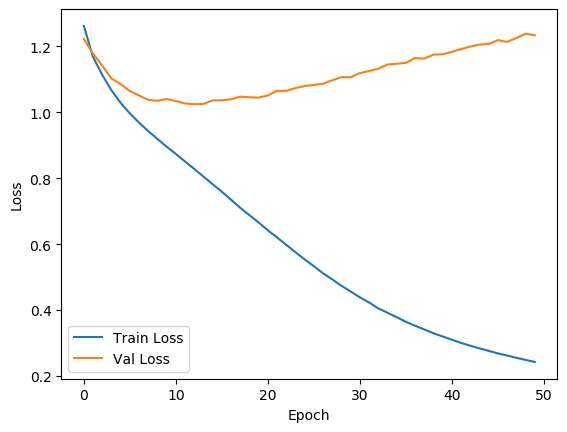

In [27]:
import matplotlib.pyplot as plt
def plot_loss_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history.epoch, np.array(history.history['loss']),
               label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val Loss')
    plt.legend()
    #plt.ylim([0.05, 1])

plot_loss_history(history)

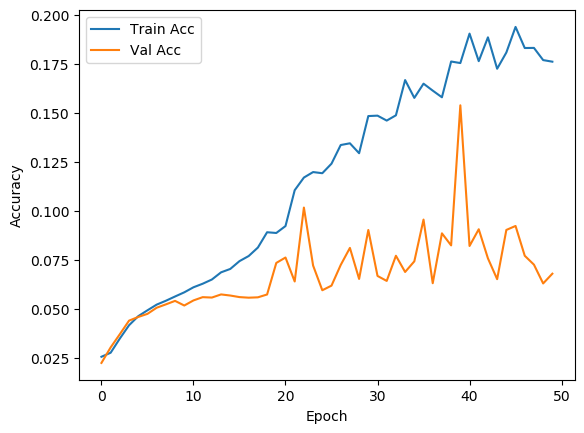

In [28]:
import matplotlib.pyplot as plt
def plot_loss_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(history.epoch, np.array(history.history['acc']),
               label='Train Acc')
    plt.plot(history.epoch, np.array(history.history['val_acc']),
           label = 'Val Acc')
    plt.legend()
    #plt.ylim([0.05, 1])

plot_loss_history(history)

# Run only when recalling new model after restarting kernel
When kernel crashes and for retraining with just 1 epoch

In [6]:
import tensorflow as tf
#Call a saved model
#tf.reset_default_graph()
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.

config_proto = tf.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.Session(config=config_proto)
set_session(session)
with tf.device('/cpu:0'):
    new_model = tf.keras.models.load_model('Project_7500_w2w_s2s_512_40e.h5')

#Run a new model with saved weights
#new_model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    new_model.summary()

#to reinstate the model, running for just one epoch
    new_history=new_model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
              batch_size=batch_size,
              epochs=1,
              validation_split=0.2)
# Save model
#new_model.save('revised_Ass3_s2s_100.h5')

W0727 20:49:50.234421  4636 deprecation.py:323] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 6567)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 6463)] 0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 512), (None, 14499840    input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 512),  14286848    input_2[0][0]                    
                                                                 lstm_1[0][1]               

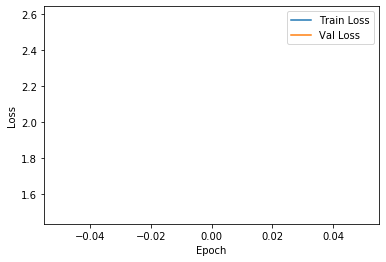

In [70]:
import matplotlib.pyplot as plt
def plot_loss_new_history(new_history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(new_history.epoch, np.array(new_history.history['loss']),
               label='Train Loss')
    plt.plot(new_history.epoch, np.array(new_history.history['val_loss']),
           label = 'Val Loss')
    plt.legend()
    #plt.ylim([0.05, 1])

plot_loss_new_history(new_history)

## Inference Mode
Re-tuning the model to accept direct inputs to Decoder along with states from encoder

In [29]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [30]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_word_index = dict(
    (i, word) for word, i in input_token_index.items())
reverse_target_word_index = dict(
    (i, word) for word, i in target_token_index.items())

Why are we saving h, c from decoder?

In [33]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['START_']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while stop_condition == False:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_word_index[sampled_token_index]
        if (sampled_word != '_END'):
            decoded_sentence += ' '+sampled_word

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == '_END' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [34]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:', target_texts[seq_index])
    print('Decoded sentence:', 'START_ '+decoded_sentence+' _END')

-
Input sentence: I do not want to die.
Target sentence: START_ मैं मरना नहीं चाहता. _END
Decoded sentence: START_  मैं तुम्हें पता है , डौग चाहते हैं , मैं एक _END
-
Input sentence: It's the same country I think.
Target sentence: START_ यह मुझे लगता है कि एक ही देश है. _END
Decoded sentence: START_  यह एक अच्छा है . _END
-
Input sentence: Then they'll be crying like babies.
Target sentence: START_ फिर ये नन्हें बच्चों की तरह रोएँगे। _END
Decoded sentence: START_  - हम अभी तक मदद के लिए पूछ नहीं है . _END
-
Input sentence: - No, I need power up!
Target sentence: START_ नहीं, मुझे पावर की जरुरत है ! _END
Decoded sentence: START_  - नहीं , मैं ऐसा नहीं करूंगा . _END
-
Input sentence: I will not eat him.
Target sentence: START_ मैं उसे नहीं खा जाएगा. _END
Decoded sentence: START_  मैं तुम्हें पता है , डौग चाहते हैं , मैं एक _END
-
Input sentence: You gotta get me to Charleston.
Target sentence: START_ आप चार्ल्सटन करने के लिए मुझे जाना होगा. _END
Decoded sentence: START_  आप मुझे पता नहीं

In [40]:
ip_seq=[]
op_seq=[]
dec_seq=[]
b1=[]
b2=[]
b3=[]
b4=[]
b_cum=[]

In [41]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_sentence = target_texts[seq_index]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:',target_sentence)
    print('Decoded sentence:','START_ '+decoded_sentence+' _END')
    x1=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(1, 0, 0, 0))
    print('Individual 1-gram: %f' % x1)
    x2=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 1, 0, 0))
    print('Individual 2-gram: %f' % x2)
    x3=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 0, 1, 0))
    print('Individual 3-gram: %f' % x3)
    x4=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0,0,0,1))
    print('Individual 4-gram: %f' % x4)
    score = sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0.25, 0.25, 0.25, 0.25))
    print('4-gram cummulative score: ',score)
    ip_seq.append(input_texts[seq_index])
    op_seq.append(target_sentence)
    dec_seq.append('START_ '+decoded_sentence+' _END')
    b1.append(x1)
    b2.append(x2)
    b3.append(x3)
    b4.append(x4)
    b_cum.append(score)

-
Input sentence: I do not want to die.
Target sentence: START_ मैं मरना नहीं चाहता. _END
Decoded sentence: START_  मैं तुम्हें पता है , डौग चाहते हैं , मैं एक _END
Individual 1-gram: 0.464286
Individual 2-gram: 0.400000
Individual 3-gram: 0.259259
Individual 4-gram: 0.188679
4-gram cummulative score:  0.3087279361290344
-
Input sentence: It's the same country I think.
Target sentence: START_ यह मुझे लगता है कि एक ही देश है. _END
Decoded sentence: START_  यह एक अच्छा है . _END
Individual 1-gram: 0.513934
Individual 2-gram: 0.447122
Individual 3-gram: 0.353282
Individual 4-gram: 0.252223
4-gram cummulative score:  0.3782767339010976
-
Input sentence: Then they'll be crying like babies.
Target sentence: START_ फिर ये नन्हें बच्चों की तरह रोएँगे। _END
Decoded sentence: START_  - हम अभी तक मदद के लिए पूछ नहीं है . _END
Individual 1-gram: 0.571429
Individual 2-gram: 0.333333
Individual 3-gram: 0.191489
Individual 4-gram: 0.130435
4-gram cummulative score:  0.26263021650846113
-
Input senten

-
Input sentence: You cannot be serious.
Target sentence: START_ आप गंभीर नहीं किया जा सकता है. _END
Decoded sentence: START_  आप एक चुड़ैल हैं ? _END
Individual 1-gram: 0.520309
Individual 2-gram: 0.374019
Individual 3-gram: 0.266005
Individual 4-gram: 0.175322
4-gram cummulative score:  0.30865292567425895
-
Input sentence: Turn over in my mind is okay, but allow me to find out your not.
Target sentence: START_ मेरे दिमाग में मुड़ें पर ठीक है, लेकिन अनुमति नहीं खोजने के लिए मुझे बाहर अपने. _END
Decoded sentence: START_  और जब मैं तुम लोग मुझे एक लंबे ले जा रहा है _END
Individual 1-gram: 0.487470
Individual 2-gram: 0.272497
Individual 3-gram: 0.158596
Individual 4-gram: 0.090893
4-gram cummulative score:  0.20918644394226255
-
Input sentence: Feels like there's something in there.
Target sentence: START_ वहाँ में कुछ है जैसे लगता है. _END
Decoded sentence: START_  यह एक अच्छा है . _END
Individual 1-gram: 0.547148
Individual 2-gram: 0.354181
Individual 3-gram: 0.293839
Individual 4-gra

-
Input sentence: Don't look astonished; she is an accomplished thief
Target sentence: START_ आशचर्य से मत देखो, वह पूरी चोर है _END
Decoded sentence: START_  क्या आप के लिए अपने माध्यम के लिए किसी की तरह _END
Individual 1-gram: 0.534483
Individual 2-gram: 0.280702
Individual 3-gram: 0.160714
Individual 4-gram: 0.109091
4-gram cummulative score:  0.22646728190019158
-
Input sentence: Will you?
Target sentence: START_ वचन नहीं निभाओगे? _END
Decoded sentence: START_  क्या तुम जानते हो , ? _END
Individual 1-gram: 0.558824
Individual 2-gram: 0.333333
Individual 3-gram: 0.281250
Individual 4-gram: 0.225806
4-gram cummulative score:  0.32979614634376314
-
Input sentence: Let's just get the money, see what happens.
Target sentence: START_ चलो बस पैसे मिल देखते हैं, क्या होता है. _END
Decoded sentence: START_  एक आदमी है . _END
Individual 1-gram: 0.298844
Individual 2-gram: 0.183948
Individual 3-gram: 0.147650
Individual 4-gram: 0.108053
4-gram cummulative score:  0.17208877219329208
-
Input s

-
Input sentence: Whoa! Astrid!
Target sentence: START_ ऐस्ट्रिड! _END
Decoded sentence: START_  हा ! _END
Individual 1-gram: 0.604376
Individual 2-gram: 0.543358
Individual 3-gram: 0.474203
Individual 4-gram: 0.395169
4-gram cummulative score:  0.49806400917479604
-
Input sentence: Let's not repeat the same mistakes that we made in the past.
Target sentence: START_ हमें पहले की गई ग़लतियां दोहरानी नहीं चाहिए। _END
Decoded sentence: START_  यह एक जाल है . _END
Individual 1-gram: 0.303657
Individual 2-gram: 0.144529
Individual 3-gram: 0.109316
Individual 4-gram: 0.085403
4-gram cummulative score:  0.1422737428810026
-
Input sentence: Jack always told me that if anything should ever happened to him.
Target sentence: START_ जैक ने मुझे हमेशा बताया कि अगर उसके साथ कुछ हुआ... _END
Decoded sentence: START_  वह एक अच्छी माँ थी न ? _END
Individual 1-gram: 0.356672
Individual 2-gram: 0.190380
Individual 3-gram: 0.112085
Individual 4-gram: 0.086691
4-gram cummulative score:  0.16027041727743263


In [42]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
for seq_index in range(3450,3550):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_sentence = target_texts[seq_index]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:',target_sentence)
    print('Decoded sentence:','START_ '+decoded_sentence+' _END')
    x1=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(1, 0, 0, 0))
    print('Individual 1-gram: %f' % x1)
    x2=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 1, 0, 0))
    print('Individual 2-gram: %f' % x2)
    x3=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 0, 1, 0))
    print('Individual 3-gram: %f' % x3)
    x4=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0,0,0,1))
    print('Individual 4-gram: %f' % x4)
    score = sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0.25, 0.25, 0.25, 0.25))
    print('4-gram cummulative score: ',score)
    ip_seq.append(input_texts[seq_index])
    op_seq.append(target_sentence)
    dec_seq.append('START_ '+decoded_sentence+' _END')
    b1.append(x1)
    b2.append(x2)
    b3.append(x3)
    b4.append(x4)
    b_cum.append(score)

-
Input sentence: I've been away from them for far too long.
Target sentence: START_ मैं उनसे दूर अभी तक बहुत लंबे समय के लिए किया गया है। _END
Decoded sentence: START_  मैं तुम्हें पता है कि लोगों को उसके लिए शोक _END
Individual 1-gram: 0.714681
Individual 2-gram: 0.464474
Individual 3-gram: 0.299614
Individual 4-gram: 0.208867
4-gram cummulative score:  0.37964405419136216
-
Input sentence: Hank, he tells me that he's found the answer to your cosmetic problem.
Target sentence: START_ हांक .. वह मुझसे कहता है, वह अपने अंगराग समस्या का जवाब मिल गया है. _END
Decoded sentence: START_  ठीक है , लेकिन आप सभी ने सुना है कि कि , _END
Individual 1-gram: 0.485203
Individual 2-gram: 0.259041
Individual 3-gram: 0.144066
Individual 4-gram: 0.085719
4-gram cummulative score:  0.19848735419983313
-
Input sentence: I have to get out of here.
Target sentence: START_ मुझे यहाँ से बाहर निकलना है. _END
Decoded sentence: START_  मैं तुम्हें पता है , डौग चाहते हैं , मैं एक _END
Individual 1-gram: 0.500000

-
Input sentence: Where are you going so urgently?
Target sentence: START_ आप इतना जरुरी कहाँ जा रहे हैं? _END
Decoded sentence: START_  क्या तुम जानते हो , क्रिस्चियन ? _END
Individual 1-gram: 0.644444
Individual 2-gram: 0.386364
Individual 3-gram: 0.255814
Individual 4-gram: 0.166667
4-gram cummulative score:  0.320987911499183
-
Input sentence: Jesus Christ.
Target sentence: START_ -जीज़स क्राइस्ट. _END
Decoded sentence: START_  हमारे पास जांच छवियों आप दुश्मन ग्रह पर क्या _END
Individual 1-gram: 0.350877
Individual 2-gram: 0.250000
Individual 3-gram: 0.163636
Individual 4-gram: 0.111111
4-gram cummulative score:  0.19984031923399137
-
Input sentence: Come on, do the bastard.
Target sentence: START_ चलो, कमीने से करते हैं। _END
Decoded sentence: START_  चलो , चलो चलते हैं . _END
Individual 1-gram: 0.713026
Individual 2-gram: 0.558834
Individual 3-gram: 0.425055
Individual 4-gram: 0.313731
4-gram cummulative score:  0.4801178105505054
-
Input sentence: - Will.
Target sentence: START_ 

-
Input sentence: VICTOR:
Target sentence: START_ विक्टर: _END
Decoded sentence: START_  वे हमारे सिर उड़ा नहीं है , हम इस शहर के बाहर _END
Individual 1-gram: 0.275862
Individual 2-gram: 0.192982
Individual 3-gram: 0.142857
Individual 4-gram: 0.109091
4-gram cummulative score:  0.16971689780937238
-
Input sentence: Fucking Laszlo.
Target sentence: START_ कमीना लैस्ज़लो. _END
Decoded sentence: START_  दुनिया की सबसे सात बिलियन है। _END
Individual 1-gram: 0.476190
Individual 2-gram: 0.292683
Individual 3-gram: 0.200000
Individual 4-gram: 0.153846
4-gram cummulative score:  0.25590200193171225
-
Input sentence: There is a case in that draw Open it, dear
Target sentence: START_ वहाँ में है कि यह खुला आकर्षित, प्रिय मामला है _END
Decoded sentence: START_  यह एक अच्छा है . _END
Individual 1-gram: 0.304452
Individual 2-gram: 0.223355
Individual 3-gram: 0.177127
Individual 4-gram: 0.127343
4-gram cummulative score:  0.19789906346564368
-
Input sentence: Sir, they were right.
Target sentence: S

-
Input sentence: You just rest.
Target sentence: START_ तुम बस आराम करो. _END
Decoded sentence: START_  आप एक लड़का , श्री बैप्टिस्ट हैं . _END
Individual 1-gram: 0.468085
Individual 2-gram: 0.282609
Individual 3-gram: 0.200000
Individual 4-gram: 0.159091
4-gram cummulative score:  0.2547102520921257
-
Input sentence: My family is more important to me than my love.
Target sentence: START_ मेरा परिवार मेरे प्यार से ज्यादा जरुरी है. _END
Decoded sentence: START_  क्या मैं इस जलती हुई बुझाने के लिए पीना चाहिए _END
Individual 1-gram: 0.620690
Individual 2-gram: 0.368421
Individual 3-gram: 0.178571
Individual 4-gram: 0.109091
4-gram cummulative score:  0.258347860938596
-
Input sentence: You can collect it later.
Target sentence: START_ तुम बाद में सामान ले सकती हो. _END
Decoded sentence: START_  आप एक चुड़ैल हैं ? _END
Individual 1-gram: 0.514003
Individual 2-gram: 0.289711
Individual 3-gram: 0.199801
Individual 4-gram: 0.155202
4-gram cummulative score:  0.2606793038010221
-
Input senten

In [43]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
for seq_index in range(6900,7000):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_sentence = target_texts[seq_index]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:',target_sentence)
    print('Decoded sentence:','START_ '+decoded_sentence+' _END')
    x1=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(1, 0, 0, 0))
    print('Individual 1-gram: %f' % x1)
    x2=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 1, 0, 0))
    print('Individual 2-gram: %f' % x2)
    x3=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 0, 1, 0))
    print('Individual 3-gram: %f' % x3)
    x4=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0,0,0,1))
    print('Individual 4-gram: %f' % x4)
    score = sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0.25, 0.25, 0.25, 0.25))
    print('4-gram cummulative score: ',score)
    ip_seq.append(input_texts[seq_index])
    op_seq.append(target_sentence)
    dec_seq.append('START_ '+decoded_sentence+' _END')
    b1.append(x1)
    b2.append(x2)
    b3.append(x3)
    b4.append(x4)
    b_cum.append(score)

-
Input sentence: What the fuck?
Target sentence: START_ बकवास क्या? अरे यार! _END
Decoded sentence: START_  क्या तुम सच में करने के लिए क्या कर रहे हैं _END
Individual 1-gram: 0.464286
Individual 2-gram: 0.290909
Individual 3-gram: 0.203704
Individual 4-gram: 0.150943
4-gram cummulative score:  0.25385686603792507
-
Input sentence: It's over?
Target sentence: START_ यह खत्म हो गया है? _END
Decoded sentence: START_  यह एक अच्छा है . _END
Individual 1-gram: 0.732907
Individual 2-gram: 0.552060
Individual 3-gram: 0.429380
Individual 4-gram: 0.297263
4-gram cummulative score:  0.4767102796077954
-
Input sentence: I can't tell you what that means to me.
Target sentence: START_ मुझे लगता है कि मेरे लिए इसका मतलब क्या आपको नहीं बता सकता. _END
Decoded sentence: START_  मैं तुम्हें पता है , डौग चाहते हैं , मैं एक _END
Individual 1-gram: 0.587424
Individual 2-gram: 0.264279
Individual 3-gram: 0.170004
Individual 4-gram: 0.129909
4-gram cummulative score:  0.24197889402972247
-
Input sentence: Y

-
Input sentence: Are there people having sex in these cars?
Target sentence: START_ लोग इन कारों में संभोग कर रहे हैं। _END
Decoded sentence: START_  वह एक अच्छी माँ थी न ? _END
Individual 1-gram: 0.500784
Individual 2-gram: 0.257757
Individual 3-gram: 0.177045
Individual 4-gram: 0.136933
4-gram cummulative score:  0.2365174346971325
-
Input sentence: Where did they steal it?
Target sentence: START_ कहाँ से चुराया? _END
Decoded sentence: START_  क्या तुम मुझे खुद के लिए बोल रहे हो ? _END
Individual 1-gram: 0.440000
Individual 2-gram: 0.285714
Individual 3-gram: 0.187500
Individual 4-gram: 0.148936
4-gram cummulative score:  0.24341454278871602
-
Input sentence: YOU'RE A LOUSY SHOT.
Target sentence: START_ आप एक घटिया शॉट हो. _END
Decoded sentence: START_  आप एक चुड़ैल हैं ? _END
Individual 1-gram: 0.677419
Individual 2-gram: 0.566667
Individual 3-gram: 0.448276
Individual 4-gram: 0.357143
4-gram cummulative score:  0.49790117097034453
-
Input sentence: Give it back, please.
Target sen

-
Input sentence: Where's Ram?
Target sentence: START_ जहां राम है? _END
Decoded sentence: START_  क्या तुम मुझे पता नहीं , बोल ? _END
Individual 1-gram: 0.465116
Individual 2-gram: 0.309524
Individual 3-gram: 0.219512
Individual 4-gram: 0.175000
4-gram cummulative score:  0.272701844762718
-
Input sentence: I was an engineer before.
Target sentence: START_ मैं पहले एक इंजीनियर था. _END
Decoded sentence: START_  मैं अपने पिता की मौत पर आप का समर्थन किया . _END
Individual 1-gram: 0.535714
Individual 2-gram: 0.345455
Individual 3-gram: 0.222222
Individual 4-gram: 0.169811
4-gram cummulative score:  0.28908101193630076
-
Input sentence: Eighty four!
Target sentence: START_ चौरासी! _END
Decoded sentence: START_  एक आदमी को . _END
Individual 1-gram: 0.520000
Individual 2-gram: 0.416667
Individual 3-gram: 0.347826
Individual 4-gram: 0.272727
4-gram cummulative score:  0.37863495563972854
-
Input sentence: - I just think...
Target sentence: START_ - मुझे लगता है ... _END
Decoded sentence: STA

-
Input sentence: Y'all don't mind,
Target sentence: START_ तुम सब कोई आपत्ति नहीं है, _END
Decoded sentence: START_  यह एक अच्छा है . _END
Individual 1-gram: 0.556216
Individual 2-gram: 0.314226
Individual 3-gram: 0.244398
Individual 4-gram: 0.169199
4-gram cummulative score:  0.29157151284204896
-
Input sentence: Kill her
Target sentence: START_ उसे मारो _END
Decoded sentence: START_  वह कहाँ है ! _END
Individual 1-gram: 0.560000
Individual 2-gram: 0.416667
Individual 3-gram: 0.347826
Individual 4-gram: 0.272727
4-gram cummulative score:  0.3857153091307505
-
Input sentence: Elysium will soon have a decent president.
Target sentence: START_ नन्दन जल्द ही एक सभ्य अध्यक्ष होगा. _END
Decoded sentence: START_  वहाँ कुछ ! _END
Individual 1-gram: 0.275656
Individual 2-gram: 0.160103
Individual 3-gram: 0.134182
Individual 4-gram: 0.105668
4-gram cummulative score:  0.15816181245415978
-
Input sentence: It's me!
Target sentence: START_ मैं हूँ! _END
Decoded sentence: START_  यह एक जाल है ! _

In [44]:
df_bleu=pd.DataFrame()
df_bleu["ip_seq"]=ip_seq
df_bleu["op_seq"]=op_seq
df_bleu["dec_seq"]=dec_seq
df_bleu["bleu_1-gram"]=b1
df_bleu["bleu_2-gram"]=b2
df_bleu["bleu_3-gram"]=b3
df_bleu["bleu_4-gram"]=b4
df_bleu["bleu_cumm_4-gram"]=b_cum

In [45]:
df_bleu.to_csv('G:\\CSUEB\\MSBA\\Summer 19\\DL_BAN676\\Project\\LSTM_1_Layer_BLEU.csv',index=False)

# After editing the csv to reflect averages

In [47]:
df_bleu_compute=pd.read_csv('G:\\CSUEB\\MSBA\\Summer 19\\DL_BAN676\\Project\\LSTM_1_Layer_BLEU.csv')

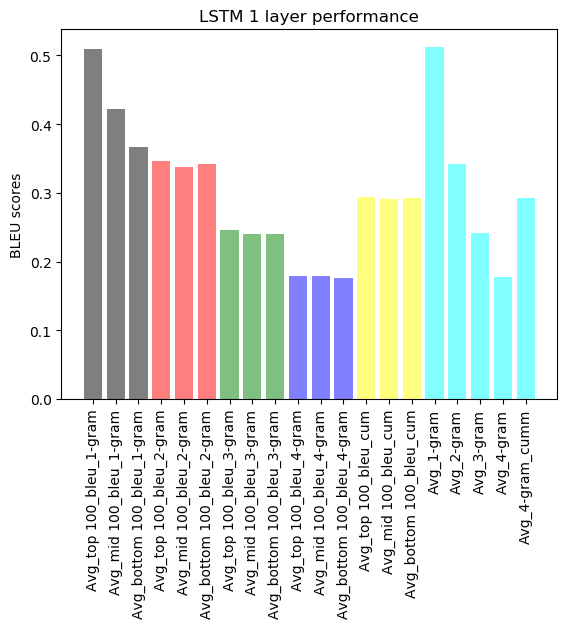

In [48]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('Avg_top 100_bleu_1-gram','Avg_mid 100_bleu_1-gram','Avg_bottom 100_bleu_1-gram','Avg_top 100_bleu_2-gram','Avg_mid 100_bleu_2-gram','Avg_bottom 100_bleu_2-gram','Avg_top 100_bleu_3-gram','Avg_mid 100_bleu_3-gram','Avg_bottom 100_bleu_3-gram','Avg_top 100_bleu_4-gram','Avg_mid 100_bleu_4-gram','Avg_bottom 100_bleu_4-gram','Avg_top 100_bleu_cum','Avg_mid 100_bleu_cum','Avg_bottom 100_bleu_cum','Avg_1-gram','Avg_2-gram','Avg_3-gram','Avg_4-gram','Avg_4-gram_cumm')
y_pos = np.arange(len(objects))

performance = [df_bleu_compute['Avg_top 100_bleu_1-gram'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_1-gram'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_1-gram'].iloc[0],
               df_bleu_compute['Avg_top 100_bleu_2-gram'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_2-gram'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_2-gram'].iloc[0],
               df_bleu_compute['Avg_top 100_bleu_3-gram'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_3-gram'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_3-gram'].iloc[0],
               df_bleu_compute['Avg_top 100_bleu_4-gram'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_4-gram'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_4-gram'].iloc[0],
               df_bleu_compute['Avg_top 100_bleu_cum'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_cum'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_cum'].iloc[0],
               df_bleu_compute['Avg_1-gram'].iloc[0],df_bleu_compute['Avg_2-gram'].iloc[0],df_bleu_compute['Avg_3-gram'].iloc[0],df_bleu_compute['Avg_4-gram'].iloc[0],df_bleu_compute['Avg_4-gram_cumm'].iloc[0]]

plt.bar(y_pos, performance, align='center', alpha=0.5, color=['black','black','black', 'red','red','red', 'green','green','green', 'blue', 'blue', 'blue', 'yellow','yellow','yellow','cyan', 'cyan', 'cyan', 'cyan', 'cyan'])
plt.xticks(y_pos, objects,rotation=90)
plt.ylabel('BLEU scores')
plt.title('LSTM 1 layer performance')

plt.show()

### The INFERENCE for simple LSTM seq2 seq model saturates quite soon. So we will try to introduces changes to the model

# --------------------------------------------------------------------------------------------------------------
# Refining model
1. Adding additional LSTM encoder layer
2. Adding additional LSTM decoder layer
3. Adding Model checkpoint based on Validation loss
# -----------------------------------------------------------------------------------------------------------

In [2]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 512  # Latent dimensionality of the encoding space.
num_samples = 7000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'cleaned_data.txt'

In [3]:
# Vectorize the data.
input_texts = []
target_texts = []
input_words = set()
target_words = set()

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    index, input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = 'START_ '+target_text+ ' _END'
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    input_word_tokens=nltk.word_tokenize(input_text)
    target_word_tokens=nltk.word_tokenize(target_text)

    for word in input_word_tokens:
        if word not in input_words:
            input_words.add(word)
    for word in target_word_tokens:
        if word not in target_words:
            target_words.add(word)
#input_words.add('')
#target_words.add('')
input_words = sorted(list(input_words))

target_words = sorted(list(target_words))

num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words)
max_encoder_seq_length = max([len(nltk.word_tokenize(txt)) for txt in input_texts])
max_decoder_seq_length = max([len(nltk.word_tokenize(txt)) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)
print('-------Word corpus-------')
#print(input_words)
#print(target_words)

Number of samples: 7000
Number of unique input tokens: 6567
Number of unique output tokens: 6463
Max sequence length for inputs: 43
Max sequence length for outputs: 43
-------Word corpus-------


In [4]:
input_token_index = dict(
    [(word, i) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i) for i, word in enumerate(target_words)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float16')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float16')

decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float16')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, word in enumerate(nltk.word_tokenize(input_text)):
        encoder_input_data[i, t, input_token_index[word]] = 1.

    for t, word in enumerate(nltk.word_tokenize(target_text)):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[word]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.

In [5]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, RNN
#layers = [256,128] # we loop LSTMCells then wrap them in an RNN layer

#EARLY STOPPING
#early_stopping = EarlyStopping(monitor='val_acc', patience=25)

#MODEL CHECKPOINT
ckpt_file = 'complex_model.h1.28_jul_19'
checkpoint = ModelCheckpoint(ckpt_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

encoder_inputs = Input(shape=(None, num_encoder_tokens))

e_outputs, h1, c1 = LSTM(latent_dim, return_state=True, return_sequences=True)(encoder_inputs) 
_, h2, c2 = LSTM(latent_dim, return_state=True)(e_outputs) 
encoder_states = [h1, c1, h2, c2]

decoder_inputs = Input(shape=(None, num_decoder_tokens))

out_layer1 = LSTM(latent_dim, return_sequences=True, return_state=True)
d_outputs, dh1, dc1 = out_layer1(decoder_inputs,initial_state= [h1, c1])
out_layer2 = LSTM(latent_dim, return_sequences=True, return_state=True)
final, dh2, dc2 = out_layer2(d_outputs, initial_state= [h2, c2])
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(final)


complex_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

complex_model.summary()

W0728 10:32:23.673350 14164 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 10:32:23.694314 14164 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 10:32:23.699292 14164 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 6567)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 6463)   0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 512),  14499840    input_1[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, None, 512),  14286848    input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [6]:
# Run training
complex_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
complex_model.summary()

W0728 10:32:26.275163 14164 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0728 10:32:26.295082 14164 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 6567)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 6463)   0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 512),  14499840    input_1[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, None, 512),  14286848    input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

# Running complex model with dual encoder and decoder layers and 512 latent_dims and batch size 64 for 100 epochs

In [7]:
complex_history=complex_model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
#model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=100,
          validation_split=0.2, callbacks=[checkpoint], verbose=1)
# Save model
#model.save('Ass3_w2w_s2s_2000_complex.h5')
complex_model.save('Proj_w2w_complex512_s2s_64b_100e_complex_rerun.h5')

W0728 10:32:33.147442 14164 deprecation.py:323] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0728 10:32:34.999122 14164 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 5600 samples, validate on 1400 samples
Epoch 1/100
5600/5600 [==============================] - 117s 21ms/step - loss: 1.3006 - acc: 0.0237 - val_loss: 1.2243 - val_acc: 0.0270

Epoch 00001: val_loss improved from inf to 1.22434, saving model to complex_model.h1.28_jul_19


c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_3 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_2/while/Exit_2:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'lstm_2/while/Exit_3:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/100
5600/5600 [==============================] - 104s 19ms/step - loss: 1.1920 - acc: 0.0269 - val_loss: 1.2276 - val_acc: 0.0274

Epoch 00002: val_loss did not improve from 1.22434
Epoch 3/100
5600/5600 [==============================] - 109s 20ms/step - loss: 1.1732 - acc: 0.0269 - val_loss: 1.2171 - val_acc: 0.0276

Epoch 00003: val_loss improved from 1.22434 to 1.21710, saving model to complex_model.h1.28_jul_19
Epoch 4/100
5600/5600 [==============================] - 105s 19ms/step - loss: 1.1293 - acc: 0.0285 - val_loss: 1.1698 - val_acc: 0.0299

Epoch 00004: val_loss improved from 1.21710 to 1.16978, saving model to complex_model.h1.28_jul_19
Epoch 5/100
5600/5600 [==============================] - 107s 19ms/step - loss: 1.0926 - acc: 0.0321 - val_loss: 1.1523 - val_acc: 0.0358

Epoch 00005: val_loss improved from 1.16978 to 1.15234, saving model to complex_model.h1.28_jul_19
Epoch 6/100
5600/5600 [==============================] - 107s 19ms/step - loss: 1.0636 - acc: 0.

5600/5600 [==============================] - 107s 19ms/step - loss: 0.3124 - acc: 0.1518 - val_loss: 1.4289 - val_acc: 0.0516

Epoch 00043: val_loss did not improve from 1.09888
Epoch 44/100
5600/5600 [==============================] - 107s 19ms/step - loss: 0.3023 - acc: 0.1532 - val_loss: 1.4351 - val_acc: 0.0518

Epoch 00044: val_loss did not improve from 1.09888
Epoch 45/100
5600/5600 [==============================] - 106s 19ms/step - loss: 0.2930 - acc: 0.1541 - val_loss: 1.4452 - val_acc: 0.0525

Epoch 00045: val_loss did not improve from 1.09888
Epoch 46/100
5600/5600 [==============================] - 106s 19ms/step - loss: 0.2829 - acc: 0.1590 - val_loss: 1.4541 - val_acc: 0.0563

Epoch 00046: val_loss did not improve from 1.09888
Epoch 47/100
5600/5600 [==============================] - 107s 19ms/step - loss: 0.2733 - acc: 0.1598 - val_loss: 1.4666 - val_acc: 0.0514

Epoch 00047: val_loss did not improve from 1.09888
Epoch 48/100
5600/5600 [==============================] - 

5600/5600 [==============================] - 107s 19ms/step - loss: 0.0637 - acc: 0.2059 - val_loss: 1.7119 - val_acc: 0.0507

Epoch 00086: val_loss did not improve from 1.09888
Epoch 87/100
5600/5600 [==============================] - 107s 19ms/step - loss: 0.0623 - acc: 0.2052 - val_loss: 1.7185 - val_acc: 0.0571

Epoch 00087: val_loss did not improve from 1.09888
Epoch 88/100
5600/5600 [==============================] - 107s 19ms/step - loss: 0.0766 - acc: 0.1999 - val_loss: 1.7131 - val_acc: 0.0488

Epoch 00088: val_loss did not improve from 1.09888
Epoch 89/100
5600/5600 [==============================] - 107s 19ms/step - loss: 0.0907 - acc: 0.2146 - val_loss: 1.7032 - val_acc: 0.0839

Epoch 00089: val_loss did not improve from 1.09888
Epoch 90/100
5600/5600 [==============================] - 111s 20ms/step - loss: 0.0702 - acc: 0.1990 - val_loss: 1.7086 - val_acc: 0.0500

Epoch 00090: val_loss did not improve from 1.09888
Epoch 91/100
5600/5600 [==============================] - 

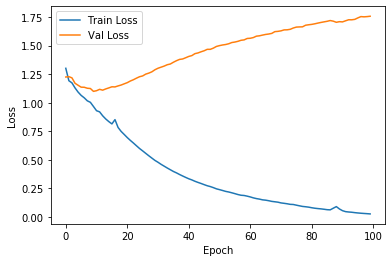

In [8]:
import matplotlib.pyplot as plt
def plot_loss_history(complex_history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(complex_history.epoch, np.array(complex_history.history['loss']),
               label='Train Loss')
    plt.plot(complex_history.epoch, np.array(complex_history.history['val_loss']),
           label = 'Val Loss')
    plt.legend()
    #plt.ylim([0.05, 1])

plot_loss_history(complex_history)

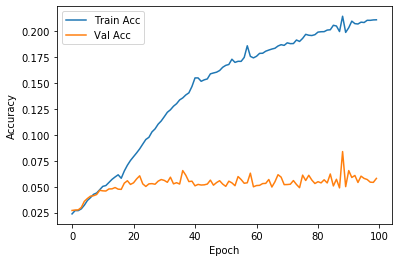

In [9]:
import matplotlib.pyplot as plt
def plot_loss_history(complex_history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(complex_history.epoch, np.array(complex_history.history['acc']),
               label='Train Acc')
    plt.plot(complex_history.epoch, np.array(complex_history.history['val_acc']),
           label = 'Val Acc')
    plt.legend()
    #plt.ylim([0.05, 1])

plot_loss_history(complex_history)

# Run only when recalling new model after restarting kernel¶
When kernel crashes and for retraining with just 1 epoch

In [7]:
import tensorflow as tf
#Call a saved model
#resume_complex_model = tf.keras.models.load_model('Ass3_s2s_2000_complex.h5')
resume_complex_model = tf.keras.models.load_model('Ass3_w2w_s2s_250_complex.h5')

resume_complex_model.summary()

#to reinstate the model, running for just one epoch
resume_complex_history=resume_complex_model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=1,
          validation_split=0.2)
# Save model
#new_model.save('revised_Ass3_s2s_200_with_space.h5')

W0721 20:09:49.464467  8816 deprecation.py:323] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 2568)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 3025)] 0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 512),  6309888     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, None, 512),  7245824     input_2[0][0]                    
                                                                 lstm_1[0][1]               

In [ ]:
import matplotlib.pyplot as plt
def plot_loss_history(resume_complex_history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(resume_complex_history.epoch, np.array(resume_complex_history.history['loss']),
               label='Train Loss')
    plt.plot(resume_complex_history.epoch, np.array(resume_complex_history.history['val_loss']),
           label = 'Val Loss')
    plt.legend()
    #plt.ylim([0.05, 1])

plot_loss_history(resume_complex_history)

In [ ]:
import matplotlib.pyplot as plt
def plot_loss_history(resume_complex_history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.plot(resume_complex_history.epoch, np.array(resume_complex_history.history['acc']),
               label='Train Acc')
    plt.plot(resume_complex_history.epoch, np.array(resume_complex_history.history['val_acc']),
           label = 'Val Acc')
    plt.legend()
    #plt.ylim([0.05, 1])

plot_loss_history(resume_complex_history)

# Complex Model Inference

In [10]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models (modified for n-layer deep network)
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_state_input_h1 = Input(shape=(latent_dim,))
decoder_state_input_c1 = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c, 
                         decoder_state_input_h1, decoder_state_input_c1]
d_o, state_h, state_c = out_layer1(
    decoder_inputs, initial_state=decoder_states_inputs[:2])
d_o, state_h1, state_c1 = out_layer2(
    d_o, initial_state=decoder_states_inputs[-2:])
decoder_states = [state_h, state_c, state_h1, state_c1]
decoder_outputs = decoder_dense(d_o)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, 6463)   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, None, 512),  14286848    input_2[0][0]                    
                                                                 input_3[0][0]                    
          

In [11]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_word_index = dict(
    (i, word) for word, i in input_token_index.items())
reverse_target_word_index = dict(
    (i, word) for word, i in target_token_index.items())

In [12]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['START_']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while stop_condition == False:
        output_tokens, h, c, h1, c1 = decoder_model.predict(
            [target_seq] + states_value) #######NOTICE THE ADDITIONAL HIDDEN STATES

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_word_index[sampled_token_index]
        if (sampled_word != '_END'):
            decoded_sentence += ' '+sampled_word
        
        # Exit condition: either hit max length
        # or find stop character.
        elif (sampled_word == '_END' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c, h1, c1]#######NOTICE THE ADDITIONAL HIDDEN STATES

    return decoded_sentence




In [13]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:', target_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: I do not want to die.
Target sentence: START_ मैं मरना नहीं चाहता. _END
Decoded sentence:  मैं मरना नहीं चाहता .
-
Input sentence: It's the same country I think.
Target sentence: START_ यह मुझे लगता है कि एक ही देश है. _END
Decoded sentence:  यह मुझे लगता है कि एक ही देश है .
-
Input sentence: Then they'll be crying like babies.
Target sentence: START_ फिर ये नन्हें बच्चों की तरह रोएँगे। _END
Decoded sentence:  फिर ये नन्हें बच्चों की तरह रोएँगे।
-
Input sentence: - No, I need power up!
Target sentence: START_ नहीं, मुझे पावर की जरुरत है ! _END
Decoded sentence:  नहीं , मैं नहीं होगा .
-
Input sentence: I will not eat him.
Target sentence: START_ मैं उसे नहीं खा जाएगा. _END
Decoded sentence:  मैं उसे नहीं खा जाएगा .
-
Input sentence: You gotta get me to Charleston.
Target sentence: START_ आप चार्ल्सटन करने के लिए मुझे जाना होगा. _END
Decoded sentence:  आप चार्ल्सटन करने के लिए मुझे जाना होगा .
-
Input sentence: - NO, HE'S NOT MY DAD.
Target sentence: START_ - नहीं, वह

# Introducing BLEU score metric at following levels:
# (Individual 1-gram, 2-gram, 3-gram, 4-gram as well as cumulative 4-gram)
## 1. Top 100 samples
## 2. middle 100 samples
## 3. last 100 samples

In [21]:
ip_seq=[]
op_seq=[]
dec_seq=[]
b1=[]
b2=[]
b3=[]
b4=[]
b_cum=[]

In [22]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_sentence = target_texts[seq_index]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:',target_sentence)
    print('Decoded sentence:','START_ '+decoded_sentence+' _END')
    x1=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(1, 0, 0, 0))
    print('Individual 1-gram: %f' % x1)
    x2=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 1, 0, 0))
    print('Individual 2-gram: %f' % x2)
    x3=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 0, 1, 0))
    print('Individual 3-gram: %f' % x3)
    x4=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0,0,0,1))
    print('Individual 4-gram: %f' % x4)
    score = sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0.25, 0.25, 0.25, 0.25))
    print('4-gram cummulative score: ',score)
    ip_seq.append(input_texts[seq_index])
    op_seq.append(target_sentence)
    dec_seq.append('START_ '+decoded_sentence+' _END')
    b1.append(x1)
    b2.append(x2)
    b3.append(x3)
    b4.append(x4)
    b_cum.append(score)

-
Input sentence: I do not want to die.
Target sentence: START_ मैं मरना नहीं चाहता. _END
Decoded sentence: START_  मैं मरना नहीं चाहता . _END
Individual 1-gram: 0.941176
Individual 2-gram: 0.909091
Individual 3-gram: 0.843750
Individual 4-gram: 0.774194
4-gram cummulative score:  0.8646402079563364
-
Input sentence: It's the same country I think.
Target sentence: START_ यह मुझे लगता है कि एक ही देश है. _END
Decoded sentence: START_  यह मुझे लगता है कि एक ही देश है . _END
Individual 1-gram: 0.956522
Individual 2-gram: 0.933333
Individual 3-gram: 0.886364
Individual 4-gram: 0.837209
4-gram cummulative score:  0.9021825013122124
-
Input sentence: Then they'll be crying like babies.
Target sentence: START_ फिर ये नन्हें बच्चों की तरह रोएँगे। _END
Decoded sentence: START_  फिर ये नन्हें बच्चों की तरह रोएँगे। _END
Individual 1-gram: 0.979167
Individual 2-gram: 0.978723
Individual 3-gram: 0.956522
Individual 4-gram: 0.933333
4-gram cummulative score:  0.961749687653068
-
Input sentence: - No

-
Input sentence: Turn over in my mind is okay, but allow me to find out your not.
Target sentence: START_ मेरे दिमाग में मुड़ें पर ठीक है, लेकिन अनुमति नहीं खोजने के लिए मुझे बाहर अपने. _END
Decoded sentence: START_  मेरे दिमाग में मुड़ें पर ठीक है , लेकिन अनुमति नहीं खोजने के लिए मुझे बाहर अपने . _END
Individual 1-gram: 0.968085
Individual 2-gram: 0.946237
Individual 3-gram: 0.913043
Individual 4-gram: 0.879121
4-gram cummulative score:  0.926004994132162
-
Input sentence: Feels like there's something in there.
Target sentence: START_ वहाँ में कुछ है जैसे लगता है. _END
Decoded sentence: START_  वहाँ में कुछ है जैसे लगता है . _END
Individual 1-gram: 0.953488
Individual 2-gram: 0.928571
Individual 3-gram: 0.878049
Individual 4-gram: 0.825000
4-gram cummulative score:  0.894902718964184
-
Input sentence: This is your honeymoon suite.
Target sentence: START_ यह अपने हनीमून सुइट है। _END
Decoded sentence: START_  यह अपने हनीमून सुइट है। _END
Individual 1-gram: 0.972222
Individual 2-gram: 

-
Input sentence: Will you?
Target sentence: START_ वचन नहीं निभाओगे? _END
Decoded sentence: START_  वचन नहीं निभाओगे ? _END
Individual 1-gram: 0.935484
Individual 2-gram: 0.900000
Individual 3-gram: 0.827586
Individual 4-gram: 0.750000
4-gram cummulative score:  0.8502337302249594
-
Input sentence: Let's just get the money, see what happens.
Target sentence: START_ चलो बस पैसे मिल देखते हैं, क्या होता है. _END
Decoded sentence: START_  चलो बस पैसे मिल देखते हैं , क्या होता है . _END
Individual 1-gram: 0.945455
Individual 2-gram: 0.907407
Individual 3-gram: 0.849057
Individual 4-gram: 0.788462
4-gram cummulative score:  0.8705426094785392
-
Input sentence: Everybody, come on!
Target sentence: START_ , वापस जाओ! , _END
Decoded sentence: START_  , वापस जाओ ! , _END
Individual 1-gram: 0.925926
Individual 2-gram: 0.884615
Individual 3-gram: 0.800000
Individual 4-gram: 0.708333
4-gram cummulative score:  0.8254002570750429
-
Input sentence: For the lady!
Target sentence: START_ महिला के लिए

Decoded sentence: START_  ऐस्ट्रिड ! _END
Individual 1-gram: 0.913043
Individual 2-gram: 0.863636
Individual 3-gram: 0.761905
Individual 4-gram: 0.650000
4-gram cummulative score:  0.7905131629932168
-
Input sentence: Let's not repeat the same mistakes that we made in the past.
Target sentence: START_ हमें पहले की गई ग़लतियां दोहरानी नहीं चाहिए। _END
Decoded sentence: START_  हमें पहले की गई ग़लतियां दोहरानी नहीं चाहिए। _END
Individual 1-gram: 0.982456
Individual 2-gram: 0.982143
Individual 3-gram: 0.963636
Individual 4-gram: 0.944444
4-gram cummulative score:  0.9680423506117729
-
Input sentence: Jack always told me that if anything should ever happened to him.
Target sentence: START_ जैक ने मुझे हमेशा बताया कि अगर उसके साथ कुछ हुआ... _END
Decoded sentence: START_  जैक ने मुझे हमेशा बताया कि अगर उसके साथ कुछ हुआ ... _END
Individual 1-gram: 0.968750
Individual 2-gram: 0.952381
Individual 3-gram: 0.919355
Individual 4-gram: 0.885246
4-gram cummulative score:  0.9308771648690893
-
Input 

In [23]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
for seq_index in range(3450,3550):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_sentence = target_texts[seq_index]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:',target_sentence)
    print('Decoded sentence:','START_ '+decoded_sentence+' _END')
    x1=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(1, 0, 0, 0))
    print('Individual 1-gram: %f' % x1)
    x2=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 1, 0, 0))
    print('Individual 2-gram: %f' % x2)
    x3=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 0, 1, 0))
    print('Individual 3-gram: %f' % x3)
    x4=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0,0,0,1))
    print('Individual 4-gram: %f' % x4)
    score = sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0.25, 0.25, 0.25, 0.25))
    print('4-gram cummulative score: ',score)
    ip_seq.append(input_texts[seq_index])
    op_seq.append(target_sentence)
    dec_seq.append('START_ '+decoded_sentence+' _END')
    b1.append(x1)
    b2.append(x2)
    b3.append(x3)
    b4.append(x4)
    b_cum.append(score)

-
Input sentence: I've been away from them for far too long.
Target sentence: START_ मैं उनसे दूर अभी तक बहुत लंबे समय के लिए किया गया है। _END
Decoded sentence: START_  मैं कई एक आदमी को खो दिया . _END
Individual 1-gram: 0.441591
Individual 2-gram: 0.301942
Individual 3-gram: 0.183116
Individual 4-gram: 0.130199
4-gram cummulative score:  0.23744831369286126
-
Input sentence: Hank, he tells me that he's found the answer to your cosmetic problem.
Target sentence: START_ हांक .. वह मुझसे कहता है, वह अपने अंगराग समस्या का जवाब मिल गया है. _END
Decoded sentence: START_  हांक .. वह मुझसे कहता है , वह अपने अंगराग समस्या का जवाब मिल गया है . _END
Individual 1-gram: 0.963415
Individual 2-gram: 0.938272
Individual 3-gram: 0.900000
Individual 4-gram: 0.860759
4-gram cummulative score:  0.9147797363071224
-
Input sentence: I have to get out of here.
Target sentence: START_ मुझे यहाँ से बाहर निकलना है. _END
Decoded sentence: START_  मुझे ये करना नहीं आता , मुझे सिखा दो . _END
Individual 1-gram: 0

-
Input sentence: Jesus Christ.
Target sentence: START_ -जीज़स क्राइस्ट. _END
Decoded sentence: START_  -जीज़स क्राइस्ट . _END
Individual 1-gram: 0.931034
Individual 2-gram: 0.892857
Individual 3-gram: 0.814815
Individual 4-gram: 0.730769
4-gram cummulative score:  0.838777415410071
-
Input sentence: Come on, do the bastard.
Target sentence: START_ चलो, कमीने से करते हैं। _END
Decoded sentence: START_  चलो , कमीने से करते हैं। _END
Individual 1-gram: 0.945946
Individual 2-gram: 0.916667
Individual 3-gram: 0.857143
Individual 4-gram: 0.794118
4-gram cummulative score:  0.8765041046371678
-
Input sentence: - Will.
Target sentence: START_ ~ ~ करेंगे. _END
Decoded sentence: START_  ~ ~ करेंगे . _END
Individual 1-gram: 0.920000
Individual 2-gram: 0.875000
Individual 3-gram: 0.782609
Individual 4-gram: 0.681818
4-gram cummulative score:  0.809566040004753
-
Input sentence: Come on, Gobber!
Target sentence: START_ चलो, गॉबर! _END
Decoded sentence: START_  चलो , गॉबर ! _END
Individual 1-gram: 0.

-
Input sentence: -Easy, Hank.
Target sentence: START_ - - आराम, हांक। _END
Decoded sentence: START_  - - आराम , हांक। _END
Individual 1-gram: 0.931034
Individual 2-gram: 0.892857
Individual 3-gram: 0.814815
Individual 4-gram: 0.730769
4-gram cummulative score:  0.838777415410071
-
Input sentence: VICTOR:
Target sentence: START_ विक्टर: _END
Decoded sentence: START_  विक्टर : _END
Individual 1-gram: 0.904762
Individual 2-gram: 0.850000
Individual 3-gram: 0.736842
Individual 4-gram: 0.611111
4-gram cummulative score:  0.7671176261207451
-
Input sentence: Fucking Laszlo.
Target sentence: START_ कमीना लैस्ज़लो. _END
Decoded sentence: START_  कमीना लैस्ज़लो . _END
Individual 1-gram: 0.931034
Individual 2-gram: 0.892857
Individual 3-gram: 0.814815
Individual 4-gram: 0.730769
4-gram cummulative score:  0.838777415410071
-
Input sentence: There is a case in that draw Open it, dear
Target sentence: START_ वहाँ में है कि यह खुला आकर्षित, प्रिय मामला है _END
Decoded sentence: START_  वहाँ में है

-
Input sentence: You just rest.
Target sentence: START_ तुम बस आराम करो. _END
Decoded sentence: START_  तुम बस आराम करो . _END
Individual 1-gram: 0.933333
Individual 2-gram: 0.896552
Individual 3-gram: 0.821429
Individual 4-gram: 0.740741
4-gram cummulative score:  0.8447185681558694
-
Input sentence: My family is more important to me than my love.
Target sentence: START_ मेरा परिवार मेरे प्यार से ज्यादा जरुरी है. _END
Decoded sentence: START_  मेरा परिवार मेरे प्यार से ज्यादा जरुरी है . _END
Individual 1-gram: 0.964286
Individual 2-gram: 0.945455
Individual 3-gram: 0.907407
Individual 4-gram: 0.867925
4-gram cummulative score:  0.9205188098957021
-
Input sentence: You can collect it later.
Target sentence: START_ तुम बाद में सामान ले सकती हो. _END
Decoded sentence: START_  तुम बाद में सामान ले सकती हो . _END
Individual 1-gram: 0.953488
Individual 2-gram: 0.928571
Individual 3-gram: 0.878049
Individual 4-gram: 0.825000
4-gram cummulative score:  0.894902718964184
-
Input sentence: Loo

In [24]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
for seq_index in range(6900,7000):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_sentence = target_texts[seq_index]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:',target_sentence)
    print('Decoded sentence:','START_ '+decoded_sentence+' _END')
    x1=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(1, 0, 0, 0))
    print('Individual 1-gram: %f' % x1)
    x2=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 1, 0, 0))
    print('Individual 2-gram: %f' % x2)
    x3=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 0, 1, 0))
    print('Individual 3-gram: %f' % x3)
    x4=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0,0,0,1))
    print('Individual 4-gram: %f' % x4)
    score = sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0.25, 0.25, 0.25, 0.25))
    print('4-gram cummulative score: ',score)
    ip_seq.append(input_texts[seq_index])
    op_seq.append(target_sentence)
    dec_seq.append('START_ '+decoded_sentence+' _END')
    b1.append(x1)
    b2.append(x2)
    b3.append(x3)
    b4.append(x4)
    b_cum.append(score)

-
Input sentence: What the fuck?
Target sentence: START_ बकवास क्या? अरे यार! _END
Decoded sentence: START_  हम सही बात है , लेकिन वह जिम्मेदारी अपने कहीं और रात करता है कि उन्हें अपने देश यात्रा , बचने ... और आप एक अजीब कर ली . _END
Individual 1-gram: 0.219697
Individual 2-gram: 0.129771
Individual 3-gram: 0.069231
Individual 4-gram: 0.046512
4-gram cummulative score:  0.09788487654303055
-
Input sentence: It's over?
Target sentence: START_ यह खत्म हो गया है? _END
Decoded sentence: START_  क्या नहीं है ? _END
Individual 1-gram: 0.762271
Individual 2-gram: 0.516253
Individual 3-gram: 0.393729
Individual 4-gram: 0.260995
4-gram cummulative score:  0.44843595037925266
-
Input sentence: I can't tell you what that means to me.
Target sentence: START_ मुझे लगता है कि मेरे लिए इसका मतलब क्या आपको नहीं बता सकता. _END
Decoded sentence: START_  मैं तुम्हें फोन पर नहीं बता सकता . _END
Individual 1-gram: 0.549039
Individual 2-gram: 0.339194
Individual 3-gram: 0.293388
Individual 4-gram: 0.245501


-
Input sentence: Are there people having sex in these cars?
Target sentence: START_ लोग इन कारों में संभोग कर रहे हैं। _END
Decoded sentence: START_  उस चुड़ैल को रोको ! _END
Individual 1-gram: 0.524589
Individual 2-gram: 0.270756
Individual 3-gram: 0.172173
Individual 4-gram: 0.133582
4-gram cummulative score:  0.23907156107690525
-
Input sentence: Where did they steal it?
Target sentence: START_ कहाँ से चुराया? _END
Decoded sentence: START_  वे उनके दुश्मन ' खोपड़ी तोड़ और धूल के रूप में उन्हें पीते हैं . _END
Individual 1-gram: 0.246753
Individual 2-gram: 0.157895
Individual 3-gram: 0.106667
Individual 4-gram: 0.081081
4-gram cummulative score:  0.13548608573272766
-
Input sentence: YOU'RE A LOUSY SHOT.
Target sentence: START_ आप एक घटिया शॉट हो. _END
Decoded sentence: START_  अब सुई ले लो ! _END
Individual 1-gram: 0.542932
Individual 2-gram: 0.331655
Individual 3-gram: 0.275937
Individual 4-gram: 0.215576
4-gram cummulative score:  0.3217070111315832
-
Input sentence: Give it back

-
Input sentence: The Jaeger program is dead, marshal.
Target sentence: START_ जैगर कार्यक्रम, मार्शल मर चुका है. _END
Decoded sentence: START_  कृपया भगवान , मुझे ये जंजीरों मिल। _END
Individual 1-gram: 0.617021
Individual 2-gram: 0.347826
Individual 3-gram: 0.200000
Individual 4-gram: 0.136364
4-gram cummulative score:  0.2765971590496772
-
Input sentence: Where's Ram?
Target sentence: START_ जहां राम है? _END
Decoded sentence: START_  आशचर्य से मत देखो , वह पूरी चोर है _END
Individual 1-gram: 0.404255
Individual 2-gram: 0.260870
Individual 3-gram: 0.200000
Individual 4-gram: 0.136364
4-gram cummulative score:  0.23158047038710655
-
Input sentence: I was an engineer before.
Target sentence: START_ मैं पहले एक इंजीनियर था. _END
Decoded sentence: START_  मैं तुम्हें दिखाता हूँ . _END
Individual 1-gram: 0.675676
Individual 2-gram: 0.416667
Individual 3-gram: 0.342857
Individual 4-gram: 0.264706
4-gram cummulative score:  0.3998075206637644
-
Input sentence: Eighty four!
Target sentence:

-
Input sentence: You're not mistaken?
Target sentence: START_ तुम गलती नहीं कर रहे हो? _END
Decoded sentence: START_  आप यहाँ नहीं आया नहीं पता है . _END
Individual 1-gram: 0.581395
Individual 2-gram: 0.380952
Individual 3-gram: 0.292683
Individual 4-gram: 0.225000
4-gram cummulative score:  0.34752058784304546
-
Input sentence: Get me facial recognition on everyone in that video now.
Target sentence: START_ उस वीडियो में हर किसी के चेहरे की पहचान करो। _END
Decoded sentence: START_  तीन दिनों तक मैं खून में लेटा रहा , अटके सुअर की तरह . _END
Individual 1-gram: 0.611940
Individual 2-gram: 0.318182
Individual 3-gram: 0.230769
Individual 4-gram: 0.140625
4-gram cummulative score:  0.28193968667679065
-
Input sentence: Your eyes are young.
Target sentence: START_ तुम्हारी आँखें युवा हैं. _END
Decoded sentence: START_  अपनी आँखें खोलें . _END
Individual 1-gram: 0.631420
Individual 2-gram: 0.510627
Individual 3-gram: 0.440196
Individual 4-gram: 0.364734
4-gram cummulative score:  0.47699186

In [28]:
df_bleu=pd.DataFrame()
df_bleu["ip_seq"]=ip_seq
df_bleu["op_seq"]=op_seq
df_bleu["dec_seq"]=dec_seq
df_bleu["bleu_1-gram"]=b1
df_bleu["bleu_2-gram"]=b2
df_bleu["bleu_3-gram"]=b3
df_bleu["bleu_4-gram"]=b4
df_bleu["bleu_cumm_4-gram"]=b_cum

In [29]:
df_bleu.to_csv('G:\\CSUEB\\MSBA\\Summer 19\\DL_BAN676\\Project\\LSTM_2_Layer_BLEU.csv',index=False)

# After editing the csv to reflect average values

In [8]:
df_bleu_compute=pd.read_csv('G:\\CSUEB\\MSBA\\Summer 19\\DL_BAN676\\Project\\LSTM_2_Layer_BLEU.csv')

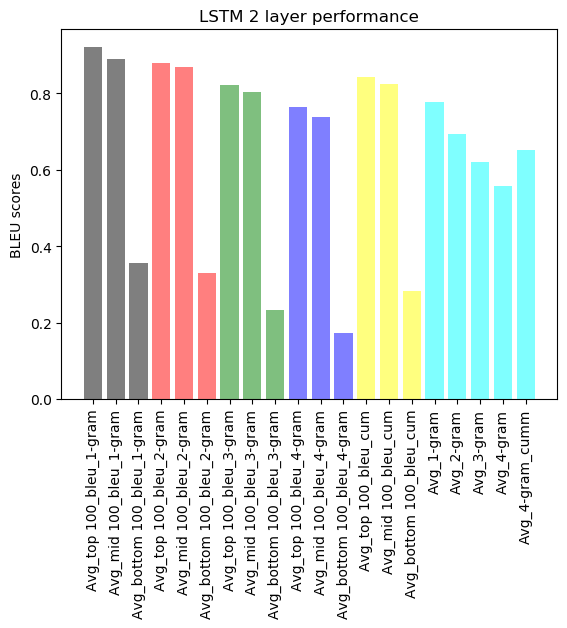

In [19]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('Avg_top 100_bleu_1-gram','Avg_mid 100_bleu_1-gram','Avg_bottom 100_bleu_1-gram','Avg_top 100_bleu_2-gram','Avg_mid 100_bleu_2-gram','Avg_bottom 100_bleu_2-gram','Avg_top 100_bleu_3-gram','Avg_mid 100_bleu_3-gram','Avg_bottom 100_bleu_3-gram','Avg_top 100_bleu_4-gram','Avg_mid 100_bleu_4-gram','Avg_bottom 100_bleu_4-gram','Avg_top 100_bleu_cum','Avg_mid 100_bleu_cum','Avg_bottom 100_bleu_cum','Avg_1-gram','Avg_2-gram','Avg_3-gram','Avg_4-gram','Avg_4-gram_cumm')
y_pos = np.arange(len(objects))

performance = [df_bleu_compute['Avg_top 100_bleu_1-gram'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_1-gram'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_1-gram'].iloc[0],
               df_bleu_compute['Avg_top 100_bleu_2-gram'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_2-gram'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_2-gram'].iloc[0],
               df_bleu_compute['Avg_top 100_bleu_3-gram'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_3-gram'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_3-gram'].iloc[0],
               df_bleu_compute['Avg_top 100_bleu_4-gram'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_4-gram'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_4-gram'].iloc[0],
               df_bleu_compute['Avg_top 100_bleu_cum'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_cum'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_cum'].iloc[0],
               df_bleu_compute['Avg_1-gram'].iloc[0],df_bleu_compute['Avg_2-gram'].iloc[0],df_bleu_compute['Avg_3-gram'].iloc[0],df_bleu_compute['Avg_4-gram'].iloc[0],df_bleu_compute['Avg_4-gram_cumm'].iloc[0]]

plt.bar(y_pos, performance, align='center', alpha=0.5, color=['black','black','black', 'red','red','red', 'green','green','green', 'blue', 'blue', 'blue', 'yellow','yellow','yellow','cyan', 'cyan', 'cyan', 'cyan', 'cyan'])
plt.xticks(y_pos, objects,rotation=90)
plt.ylabel('BLEU scores')
plt.title('LSTM 2 layer performance')

plt.show()